<a href="https://colab.research.google.com/github/wafa17/Data-Mining/blob/main/TubesDamiClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

# **Import Data**

Pada tahap ini akan melakukan import data dan membaca dataset yang digunakan

In [ ]:
df = pd.read_csv('train.csv', sep='|')
print(df.shape)
df.head()

(1879, 10)


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [ ]:
dt = pd.read_csv('test.csv', sep='|')
print(dt.shape)
dt.head()

(498121, 9)


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


# **Data Understanding**

Terdapat 2 buah dataset yang diberikan. 


1.   data train
2.   data test

Kedua data ini merupakan data yang memiliki label di tiap datanya.  Berdasarkan data yang ada, kasus ini dapat diselesaikan dengan menggunakan pendekatan **supervised learning**. Artinya, melakukan **klasifikasi** atau **regresi** terhadap data train dan data test. 



In [ ]:
df.sample(5)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
1554,4,577,93.37,9,9,1,0.046794,0.161820,0.333333,0
614,5,1210,34.00,8,2,1,0.014050,0.028099,0.470588,0
1823,4,1178,74.02,11,6,3,0.013582,0.062835,0.687500,0
1109,4,109,39.02,3,0,4,0.055046,0.357982,0.500000,0
297,2,809,21.21,0,7,5,0.021014,0.026218,0.000000,0


Sebelum melakukan klasifikasi, lebih baik mengetahui dengan baik data yang digunakan dan karakteristik dari atribut yang ada pada dataset yang digunakan 

*   **Trust Level** : customer trust level ada pada rentang 1-6
*   **Total Scanned Item in Sec** : total item scanned dalam detik antara produk saat pertama di scan dan terakhir kali di scan
*   **Grand Total** : total produk yang telah di scann
*   **Line Item Voids** : nomor produk yang batal di scan
*   **Scans without registration** : Terhitung melakukan scan padahal tidak melakukan scan
*   **Quantitiy Modifications** : Jumlah kuantitas yang dimodivikasi
*   **Scanned Line item per seconds** : jumlah rata-rata produk yang discan
*   **Value per second** : total rata-rata nilai per detik
*   **Line item void per second** : Rata-rata jumlah item kosong per total semua produk yang dipindai dan tidak dibatalkan
*   **Fraud** : label yang akan digunakan sebagai klasifikasi






# **Data Preparation/Preprocessing**

**1. Data Cleaning**
---
pada tahap ini akan dilakukan :

1.   Cek tipe data
2.   Cek apakah ada data yang missing atau bernilai NaN

In [ ]:
df.dtypes

trustLevel                     int64
totalScanTimeInSeconds         int64
grandTotal                   float64
lineItemVoids                  int64
scansWithoutRegistration       int64
quantityModifications          int64
scannedLineItemsPerSecond    float64
valuePerSecond               float64
lineItemVoidsPerPosition     float64
fraud                          int64
dtype: object

Berdasarkan hasil diatas, didapatkan tipe data keseluruhan adalah object. Untuk **atribut trustlevel, totalscantimeperseconds, lineitemvoids, scanswithoutregistration,quantitymodifications, dan fraud merupakan integer**
Sedangkan atribut **grandtotal, scannedlineitempersecond, valuepersecond, dan lineitemvoidpersecond merupakan datatype float.**

In [ ]:
print(df.isnull().sum()) #pengecekan data yang bernilai Nan

trustLevel                   0
totalScanTimeInSeconds       0
grandTotal                   0
lineItemVoids                0
scansWithoutRegistration     0
quantityModifications        0
scannedLineItemsPerSecond    0
valuePerSecond               0
lineItemVoidsPerPosition     0
fraud                        0
dtype: int64



## **2. Feature Selection**

---

Fitur yang akan digunakan pada klasifikasi sangat menentukan hasil yang akan didapatkan. Fitur yang memiliki kedekatan tinggi akan menghasilkan klasifikasi yang lebih baik. Oleh karena itu, dilakukan pemilihan fitur terlebih dahulu dengan mecari fitur yang memiliki korelasi paling tinggi yang akan digunakan untuk klasifikasi.


1. Menentukan total item dengan mengalikan totalScannedTimeinSeconds dengan scannedItemsPerSecond dan menjadikan total item sebagai fitur baru

In [ ]:
#Menampilkan total scanned line item dengan megalikan "scanned line item per second" dengan "total scan item in second"
df['scannedLineItems'] = (df['totalScanTimeInSeconds']*df['scannedLineItemsPerSecond']).apply(lambda x: np.around(x, 2))
dt['scannedLineItems'] = (dt['totalScanTimeInSeconds']*dt['scannedLineItemsPerSecond']).apply(lambda x: np.around(x, 2))

2. Mengubah tipe data total scanned line item menjadi integer

In [ ]:
# convert data type ke integer
df['scannedLineItems'] = df['scannedLineItems'].astype(int)
dt['scannedLineItems'] = dt['scannedLineItems'].astype(int)

In [ ]:
# mengganti posisi kolom fraud dan scannedLineItems
df_temp_1 = df.pop('scannedLineItems') 
df_temp_2 = df.pop('fraud') 
df['scannedLineItems']=df_temp_1 
df['fraud']=df_temp_2

3. Melakukan ploting untuk mengecek koreasi antar fitur menggunakan matriks korelasi

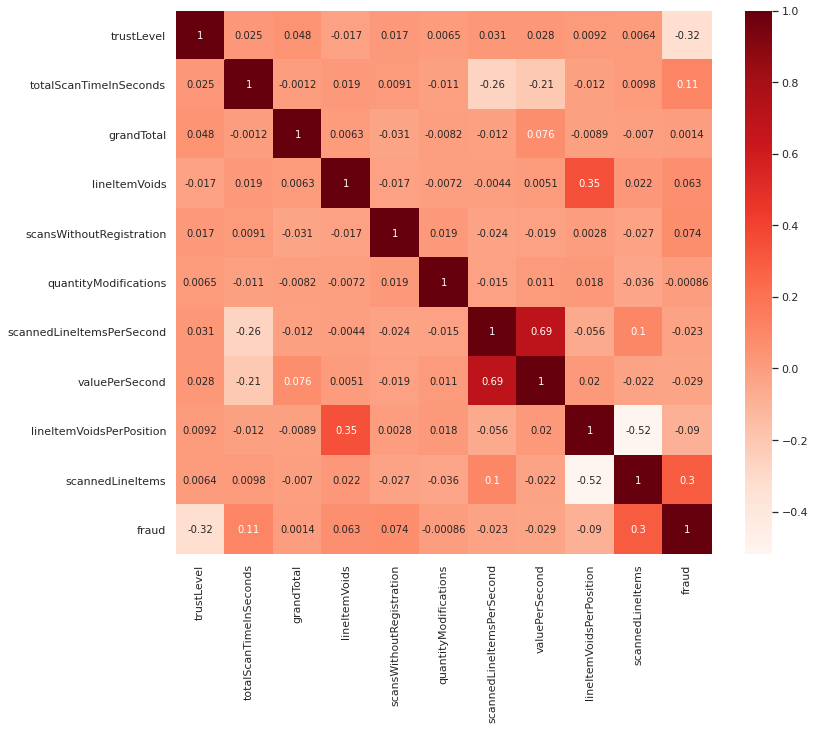

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#Menggunakan Matriks korelasi
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Fitur yang memiliki korelasi rendah atau dibawah 0.02 (nilai absolut) akan dihapus dan tidak digunakan dalam klasifikasi.

In [ ]:
cor_target = abs(cor["fraud"])
#Memilih korelasi tertinggi
relevant_features = cor_target[cor_target>0.02]
relevant_features

trustLevel                   0.319765
totalScanTimeInSeconds       0.110414
lineItemVoids                0.063496
scansWithoutRegistration     0.074123
scannedLineItemsPerSecond    0.023085
valuePerSecond               0.028873
lineItemVoidsPerPosition     0.090116
scannedLineItems             0.298423
fraud                        1.000000
Name: fraud, dtype: float64

4. Menghapus fitur yang memiliki korelasi rendah dan mempertahankan fitur yang memiliki korelasi tinggi atau lebih dari 0.02 terhadap fitur fraud

In [ ]:
# Mempertahankan fitur yang memiliki korelasi tinggi
df = df[relevant_features.index.values] # dataset train
dt = dt[relevant_features.iloc[:-1].index.values] # dataset test

## **3. Outlier Detection**


---

Outlier adalah pengamatan yang terletak pada jarak abnormal dari nilai lain dalam sampel acak dari suatu populasi.Adanya Outliers bisa menyebabkan bias.


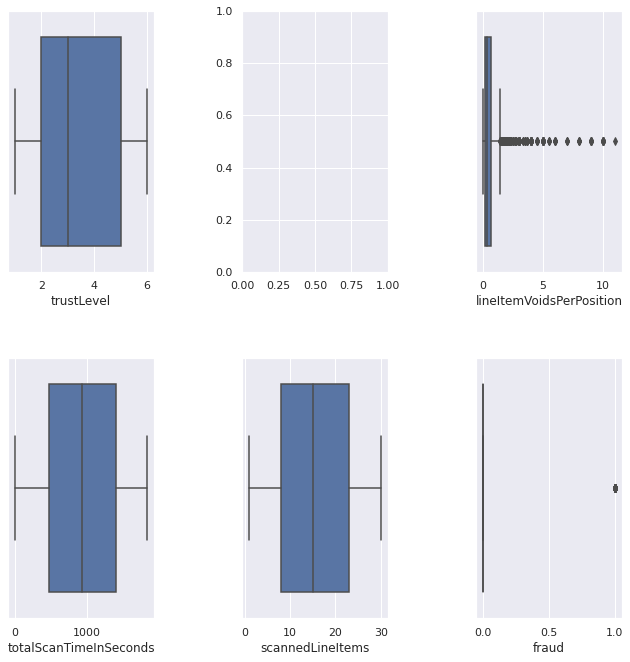

In [ ]:
def plot_boxplots(df):
    fig, axs = plt.subplots(nrows=2, ncols=3,squeeze = True)
    fig.tight_layout()
    fig.set_figheight(10)
    fig.set_figwidth(10)

    sns.boxplot(x=df['trustLevel'], ax=axs[0,0])
    sns.boxplot(x=df['totalScanTimeInSeconds'], ax=axs[1,0])
    sns.boxplot(x=df['lineItemVoidsPerPosition'], ax=axs[0,2])
    sns.boxplot(x=df['scannedLineItems'], ax=axs[1,1])
    sns.boxplot(x=df['fraud'],ax=axs[1,2])
    
plot_boxplots(df)

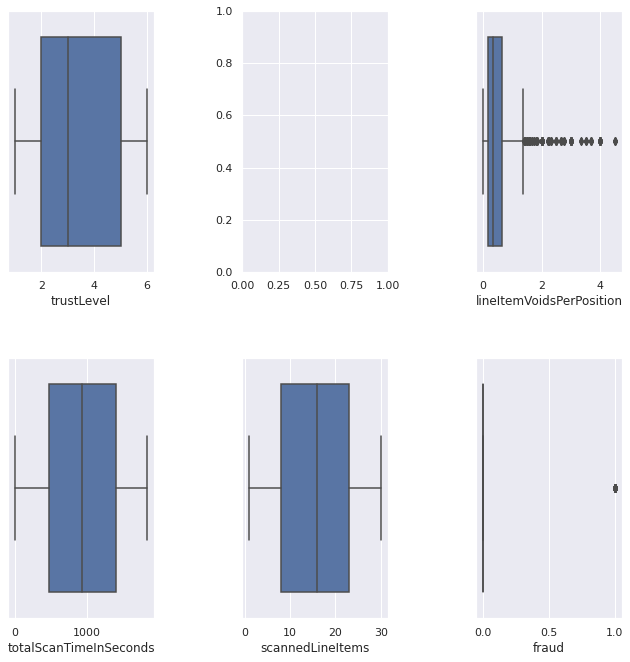

In [ ]:
# Hapus outlier pada "LineItemVoidsPerPositions" dengan mempertahankan hanya baris dalam rentang +3 sampai-3 dari standar deviasi
df = df[np.abs(df.lineItemVoidsPerPosition-df.lineItemVoidsPerPosition.mean()) <= (3*df.lineItemVoidsPerPosition.std())]

plot_boxplots(df)

## **4. Handling Imbalanced Data**


---
Mengatasi data yang tidak balance antara fraud dan non fraud menggunakan SMOTE (Synthetic Minority Over Sampling).Teknik ini mensintesis sampel baru dari kelas minoritas untuk menyeimbangkan dataset dengan cara sampling ulang sampel kelas minoritas.


In [ ]:
fraud_names = {0:'Not Fraud', 1:'Fraud'}
print(df.fraud.value_counts().rename(index = fraud_names))

Not Fraud    1727
Fraud         104
Name: fraud, dtype: int64


0    1727
1     104
Name: fraud, dtype: int64


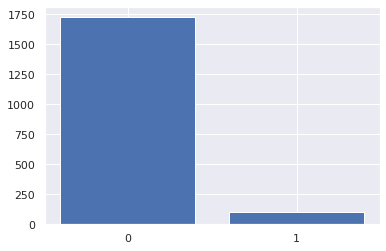

In [ ]:
classification = df['fraud'].value_counts()
print(classification)
N = 2
y_values = classification.values
x_values = [0,1]
ind = np.arange(N)
plt.bar(x_values,y_values)
plt.xticks(ind, ('0','1'))
plt.show()

**Oversampling minority class menggunakan SMOTE**

In [ ]:
import numpy as np
import warnings
from imblearn.over_sampling import SMOTE

warnings.simplefilter(action='ignore', category=FutureWarning) # for readability purposes
sm = SMOTE(random_state=np.random.seed(1304), ratio=1.0)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


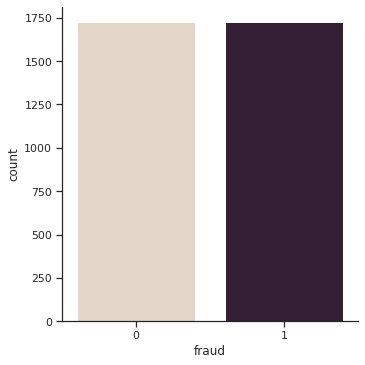

In [ ]:
# check new class counts
sns.set(style="ticks", color_codes=True)
sns.catplot(x="fraud", kind="count", palette="ch:.25", data=pd.DataFrame(data=y_train, columns=['fraud']));

# **Modelling dan Evaluasi**

Pemodelan akan dilakukan pada beberapa metode dan akan dilihat metode mana yang memiliki akurasi paling besar.
Metode yang akan digunakan yaitu :


1.   K-Nearest Neighbor
2.   Naive Bayes
3.   Decision Tree
4.   Logistic Regression




Sebelum melakukan pemodelan, data akan displit menjadi data train dan data test. 

*   **X_train** dan **y_train** diambil dari dataset train
*   **X_test** diambil dari dataset test
*  **y_test** diambil dari dataset realclass, data ini digunakan untuk mengecek akurasi dari setiap model yang digunakan. Data realclass didapatkan dari hasil prediksi pada kasus Data Mining Cup 2019


In [ ]:
#split data menjadi data test dan data train
from sklearn.model_selection import train_test_split

X_train, y_train = sm.fit_sample(df.drop(columns=['fraud']), df['fraud'])

X_test = dt
y_test = pd.read_csv('realclass.csv', sep="|")

# Menampilkan training dan testing data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3454, 8)
(498121, 8)
(3454,)
(498121, 1)


In [ ]:
# scaler digunakan untuk scalling data karena adanya perbedaan rentang data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## **1. Knn Classification**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix 

#klasifikasi menggunakan KNN (library)
klasifikasi = KNeighborsClassifier(n_neighbors=5) #umumya menggunakan n_neighbors = 5
klasifikasi.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
# Menentukan hasil prediksi dari x_test
y_pred = klasifikasi.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
# probabilitas hasil prediksi x_test
klasifikasi.predict_proba(X_test)

array([[1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [0.2, 0.8]])

**Evaluasi**

In [ ]:
# Menampilkan hasil confussion matriks 
print(confusion_matrix(y_test, y_pred))

[[450954  23440]
 [   389  23338]]


In [ ]:
# menampilkan hasil clasifikasi,precision, recall, f1score, accuracy dan support
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    474394
           1       0.50      0.98      0.66     23727

    accuracy                           0.95    498121
   macro avg       0.75      0.97      0.82    498121
weighted avg       0.98      0.95      0.96    498121



In [ ]:
#menampilkan hasil akurasi data
from sklearn.metrics import accuracy_score
accuracyKnn= accuracy_score(y_test, y_pred)*100
accuracyKnn

95.216222564397

## **2.Naive Bayes Classsification**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# Mengaktifkan/memanggil/membuat fungsi klasifikasi Naive bayes
modelnb = GaussianNB()
# Memasukkan data training pada fungsi klasifikasi naive bayes
nbtrain = modelnb.fit(X_train, y_train)
nbtrain.class_count_

array([1727., 1727.])

In [ ]:
y_p = nbtrain.predict(X_test)
y_p

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Menentukan probabilitas hasil prediksi
nbtrain.predict_proba(X_test)

array([[1.00000000e+000, 3.15024811e-034],
       [9.99358176e-001, 6.41824053e-004],
       [1.00000000e+000, 1.11149757e-230],
       ...,
       [1.00000000e+000, 1.19141543e-018],
       [9.99999994e-001, 5.83979496e-009],
       [9.99636961e-001, 3.63039372e-004]])

**Evaluasi**

In [ ]:
# Menampilkan confussion matriks untuk naive bayes 
confusion_matrix(y_test, y_p)

array([[435743,  38651],
       [  1073,  22654]])

In [ ]:
# Menampilkan klasifikasi, precision,recall, f1 score, support dan accuracy dengan naive bayes
print(classification_report(y_test,y_p))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96    474394
           1       0.37      0.95      0.53     23727

    accuracy                           0.92    498121
   macro avg       0.68      0.94      0.74    498121
weighted avg       0.97      0.92      0.94    498121



In [ ]:
from sklearn.metrics import accuracy_score
accuracyNB= accuracy_score(y_test, y_p)*100
accuracyNB #akurasi untuk naive bayes 

92.02523081741182

## **3. Decision Tree**

In [ ]:
# Decision Tree model 
from sklearn import tree

dtc = tree.DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)
 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
y_prediksi =dtc.predict(X_test)
y_prediksi

array([0, 0, 0, ..., 0, 0, 0])

**Evaluasi**

In [ ]:
# Menampilkan confussion matriks untuk naive bayes 
confusion_matrix(y_test, y_prediksi)

array([[468220,   6174],
       [  4736,  18991]])

In [ ]:
# Menampilkan klasifikasi, precision,recall, f1 score, support dan accuracy dengan naive bayes
print(classification_report(y_test,y_prediksi))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    474394
           1       0.75      0.80      0.78     23727

    accuracy                           0.98    498121
   macro avg       0.87      0.89      0.88    498121
weighted avg       0.98      0.98      0.98    498121



In [ ]:
from sklearn.metrics import accuracy_score
accuracyDCT= accuracy_score(y_test, y_prediksi)*100
accuracyDCT #akurasi untuk naive bayes 

97.80976911232412

## **4. Logistic Regression** 

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit (X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pre = nbtrain.predict(X_test)
y_pre

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Menampilkan confussion matriks untuk naive bayes 
confusion_matrix(y_test, y_pre)

array([[435743,  38651],
       [  1073,  22654]])

In [ ]:
# Menampilkan klasifikasi, precision,recall, f1 score, support dan accuracy dengan naive bayes
print(classification_report(y_test,y_pre))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96    474394
           1       0.37      0.95      0.53     23727

    accuracy                           0.92    498121
   macro avg       0.68      0.94      0.74    498121
weighted avg       0.97      0.92      0.94    498121



**Evaluasi**

In [ ]:
from sklearn.metrics import accuracy_score
accuracyLR= accuracy_score(y_test, y_pre)*100
accuracyLR #akurasi untuk naive bayes 

92.02523081741182

# **Perbandingan Akurasi untuk Setiap Model** 

In [ ]:
print('Accuracy untuk K-Nearest Neighbor    : ',accuracyKnn)
print('Accuracy untuk Naive Bayes           : ',accuracyNB)
print('Accuracy untuk Decision Tree         : ',accuracyDCT)
print('Accuracy untuk Logistik Regression   : ',accuracyLR)

Accuracy untuk K-Nearest Neighbor    :  95.216222564397
Accuracy untuk Naive Bayes           :  92.02523081741182
Accuracy untuk Decision Tree         :  97.80976911232412
Accuracy untuk Logistik Regression   :  92.02523081741182


Berdasarkan hasil perbandingan akurasi diatas, didapatkan bahwa Pemodelan menggunakan **Decision Tree** mendapatkan hasil yang lebih **maksimal** dibandingkan menggunakan model algoritma KNN,Naive Bayes, dan Logistik Regression.

In [ ]:
import numpy as np

np.savetxt("hasilPrediksiFraud.csv", y_prediksi, delimiter=",")

In [ ]:
from google.colab import files
files.download("hasilPrediksiFraud.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>